### Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint




In [2]:
!pip install seaborn

## Question 1:
### Data Exploration & Preparation:

Training data size: 60000 images
Testing data size: 10000 images
Image dimensions (Training): 28x28
Image dimensions (Testing): 28x28
Number of unique classes: 10


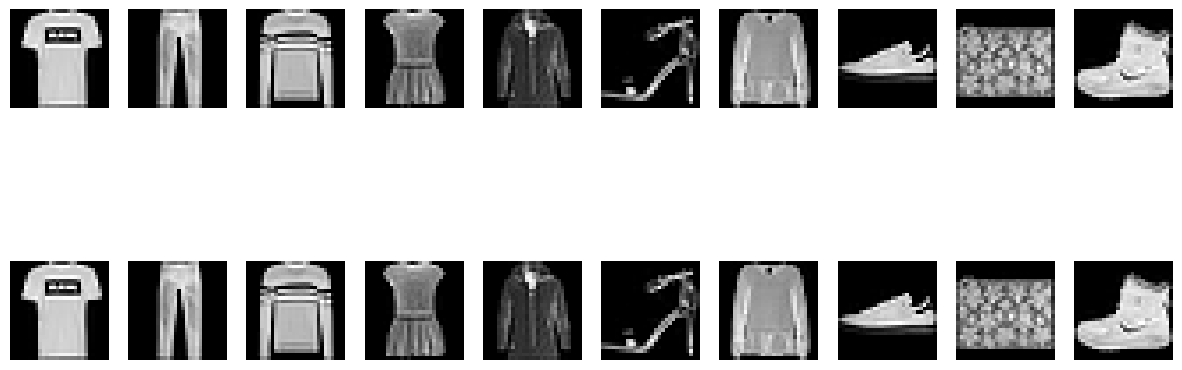

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Verify the size of the datasets
print(f"Training data size: {x_train.shape[0]} images")
print(f"Testing data size: {x_test.shape[0]} images")

# Verify the dimensions of each image
print(f"Image dimensions (Training): {x_train.shape[1]}x{x_train.shape[2]}")
print(f"Image dimensions (Testing): {x_test.shape[1]}x{x_test.shape[2]}")

# Verify the number of classes
print(f"Number of unique classes: {len(np.unique(y_train))}")

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Visualizing sample images (20 images in this case)
fig, ax = plt.subplots(2, 10, figsize=(15, 6))  # 2 rows, 10 columns
for i in range(20):
    ax[i // 10, i % 10].imshow(x_train[y_train.argmax(axis=1) == i % 10][0], cmap='gray')
    ax[i // 10, i % 10].axis('off')
plt.show()

### Data Splitting:

In [3]:
# 1. Load the entire Fashion MNIST (60K train + 10K test = 70K total)
(x0, y0), (x1, y1) = fashion_mnist.load_data()
x = np.concatenate([x0, x1], axis=0)
y = np.concatenate([y0, y1], axis=0)

# 2. Normalize and reshape
x = x.astype("float32") / 255.0
x = x.reshape(-1, 28, 28, 1)
y = to_categorical(y, 10)

# 3. First split off 4% for test
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y,
    test_size=0.04,
    random_state=42,
    stratify=y
)

# 4. Then split the remaining 96% into 85% train + 10% val:
val_rel = 0.10 / 0.96
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp,
    test_size=val_rel,
    random_state=42,
    stratify=y_temp
)
total = len(x)
print(f"Train  : {len(x_train)/total*100:5.2f}%")
print(f"Val    : {len(x_val)  /total*100:5.2f}%")
print(f"Test   : {len(x_test) /total*100:5.2f}%")


Train  : 86.00%
Val    : 10.00%
Test   :  4.00%


### Model Development without batch normalization

In [4]:
# Model 1: Shallow Neural Network
model1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Model 2: Basic CNN
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Model 3: Deeper CNN
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Print summaries of models
model1.summary()
model2.summary()
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,522 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training & Validation:

#### Training Model 1:

In [8]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("NumS:", len(tf.config.list_physical_devices('GPU')))


TF version: 2.19.0
NumS: 0


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [ ]:
# 1. Create the checkpoint callback
checkpoint1 = ModelCheckpoint(
    'model1_weights.h5',   # filepath to save the best weights
    monitor='val_loss',         # metric to monitor
    save_best_only=True,        # only save when val_loss improves
    mode='min',                 # we want to minimize val_loss
    verbose=1
)

# 2. Train with the callback
history1 = model1.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint1]     # add the checkpoint here
)

# (Optional) If you still want to save the final weights at the end:
# model1.save_weights('model1_final_weights.h5')


Epoch 1/10
1860/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.9132 - loss: 0.2339
Epoch 1: val_loss improved from inf to 0.30437, saving model to model1_best_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9132 - loss: 0.2340 - val_accuracy: 0.8909 - val_loss: 0.3044
Epoch 2/10
1837/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.9171 - loss: 0.2208
Epoch 2: val_loss did not improve from 0.30437
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.9171 - loss: 0.2209 - val_accuracy: 0.8900 - val_loss: 0.3176
Epoch 3/10
1826/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.9175 - loss: 0.2167
Epoch 3: val_loss did not improve from 0.30437
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.9175 - loss: 0.2168 - val_accuracy: 0.8896 - val_loss: 0.3113
Epoch 4/10
1876/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9207 - loss: 0.2117
Epoch 4: val_loss did not improve from 0.30437
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.9207 - loss: 0.2117 - val_accuracy: 0.8900 - val_loss: 0.3188
Epoch 5/10
1850/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.9224 - loss: 0.2073
Epoch 5: val_lo

#### Training Model 2:

In [16]:
# 1. Create the checkpoint callback for model2
checkpoint2 = ModelCheckpoint(
    'model2_weights.h5',  # filepath to save the best weights
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # only save when val_loss improves
    mode='min',                        # we want to minimize val_loss
    verbose=1
)

# 2. Train model2 with the checkpoint callback
history2 = model2.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint2]            
)


Epoch 1/10
1877/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0531
Epoch 1: val_loss improved from inf to 0.33038, saving model to model2_best_weights.weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9817 - loss: 0.0532 - val_accuracy: 0.9174 - val_loss: 0.3304
Epoch 2/10
1874/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0427
Epoch 2: val_loss did not improve from 0.33038
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9856 - loss: 0.0427 - val_accuracy: 0.9146 - val_loss: 0.3641
Epoch 3/10
1878/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0382
Epoch 3: val_loss did not improve from 0.33038
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9865 - loss: 0.0382 - val_accuracy: 0.9187 - val_loss: 0.3733
Epoch 4/10
1872/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9892 - loss: 0.0315
Epoch 4: val_loss did not improve from 0.33038
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9892 - loss: 0.0315 - val_accuracy: 0.9050 - val_loss: 0.5053
Epoch 5/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0292
Epoch 5: val_loss did not impro

#### Training Model 3:

In [17]:
# Define the checkpoint callback to save the best weights based on validation loss
checkpoint_callback = ModelCheckpoint(
    'model3_weights.h5',      # Save the best weights to this file
    monitor='val_loss',            # Monitor the validation loss
    save_best_only=True,           # Only save the best weights (when validation loss improves)
    mode='min',                    # 'min' means we want to minimize the validation loss
    verbose=1
)

# Train the model with the checkpoint callback
history3 = model3.fit(
    x_train, 
    y_train, 
    epochs=10, 
    validation_data=(x_val, y_val), 
    callbacks=[checkpoint_callback] 
)


Epoch 1/10
1881/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9819 - loss: 0.0510
Epoch 1: val_loss improved from inf to 0.35920, saving model to model3_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9819 - loss: 0.0510 - val_accuracy: 0.9130 - val_loss: 0.3592
Epoch 2/10
1877/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.0424
Epoch 2: val_loss did not improve from 0.35920
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9842 - loss: 0.0424 - val_accuracy: 0.9144 - val_loss: 0.4061
Epoch 3/10
1879/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9842 - loss: 0.0432
Epoch 3: val_loss did not improve from 0.35920
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9842 - loss: 0.0432 - val_accuracy: 0.9124 - val_loss: 0.4110
Epoch 4/10
1880/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9876 - loss: 0.0335
Epoch 4: val_loss did not improve from 0.35920
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9876 - loss: 0.0335 - val_accuracy: 0.9154 - val_loss: 0.4258
Epoch 5/10
1878/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9891 - loss: 0.0303
Epoch 5: val_loss d

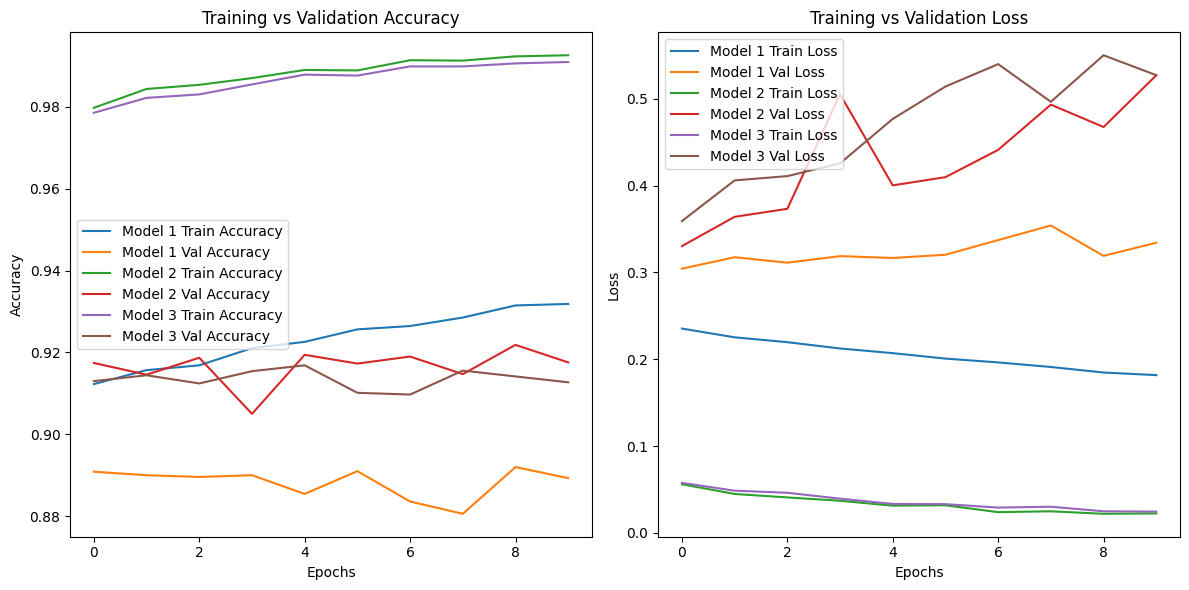

In [18]:
# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 Val Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Val Accuracy')
plt.plot(history3.history['accuracy'], label='Model 3 Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Model 3 Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Train Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2.history['loss'], label='Model 2 Train Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Val Loss')
plt.plot(history3.history['loss'], label='Model 3 Train Loss')
plt.plot(history3.history['val_loss'], label='Model 3 Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

#### Assess each model's performance on the test data, reporting accuracy.

In [19]:
test_loss, test_acc = model1.evaluate(x_test, y_test)
print(f"Test accuracy of Model 1: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.8851 - loss: 0.3821
Test accuracy of Model 1: 0.8889285922050476


In [20]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f"Test accuracy of Model 2: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9277 - loss: 0.4021
Test accuracy of Model 2: 0.9228571653366089


In [21]:
test_loss, test_acc = model3.evaluate(x_test, y_test)
print(f"Test accuracy of Model 3: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9274 - loss: 0.4656
Test accuracy of Model 3: 0.9189285635948181


#### - Construct a committee by averaging predictions of the three models.
#### - Report on the combined accuracy of the committee.

In [22]:
# Get predictions for each model
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by averaging the predicted probabilities
final_predictions = (predictions1 + predictions2 + predictions3) / 3

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Committee accuracy: 0.9317857142857143


### Performance Metrics & Analysis:

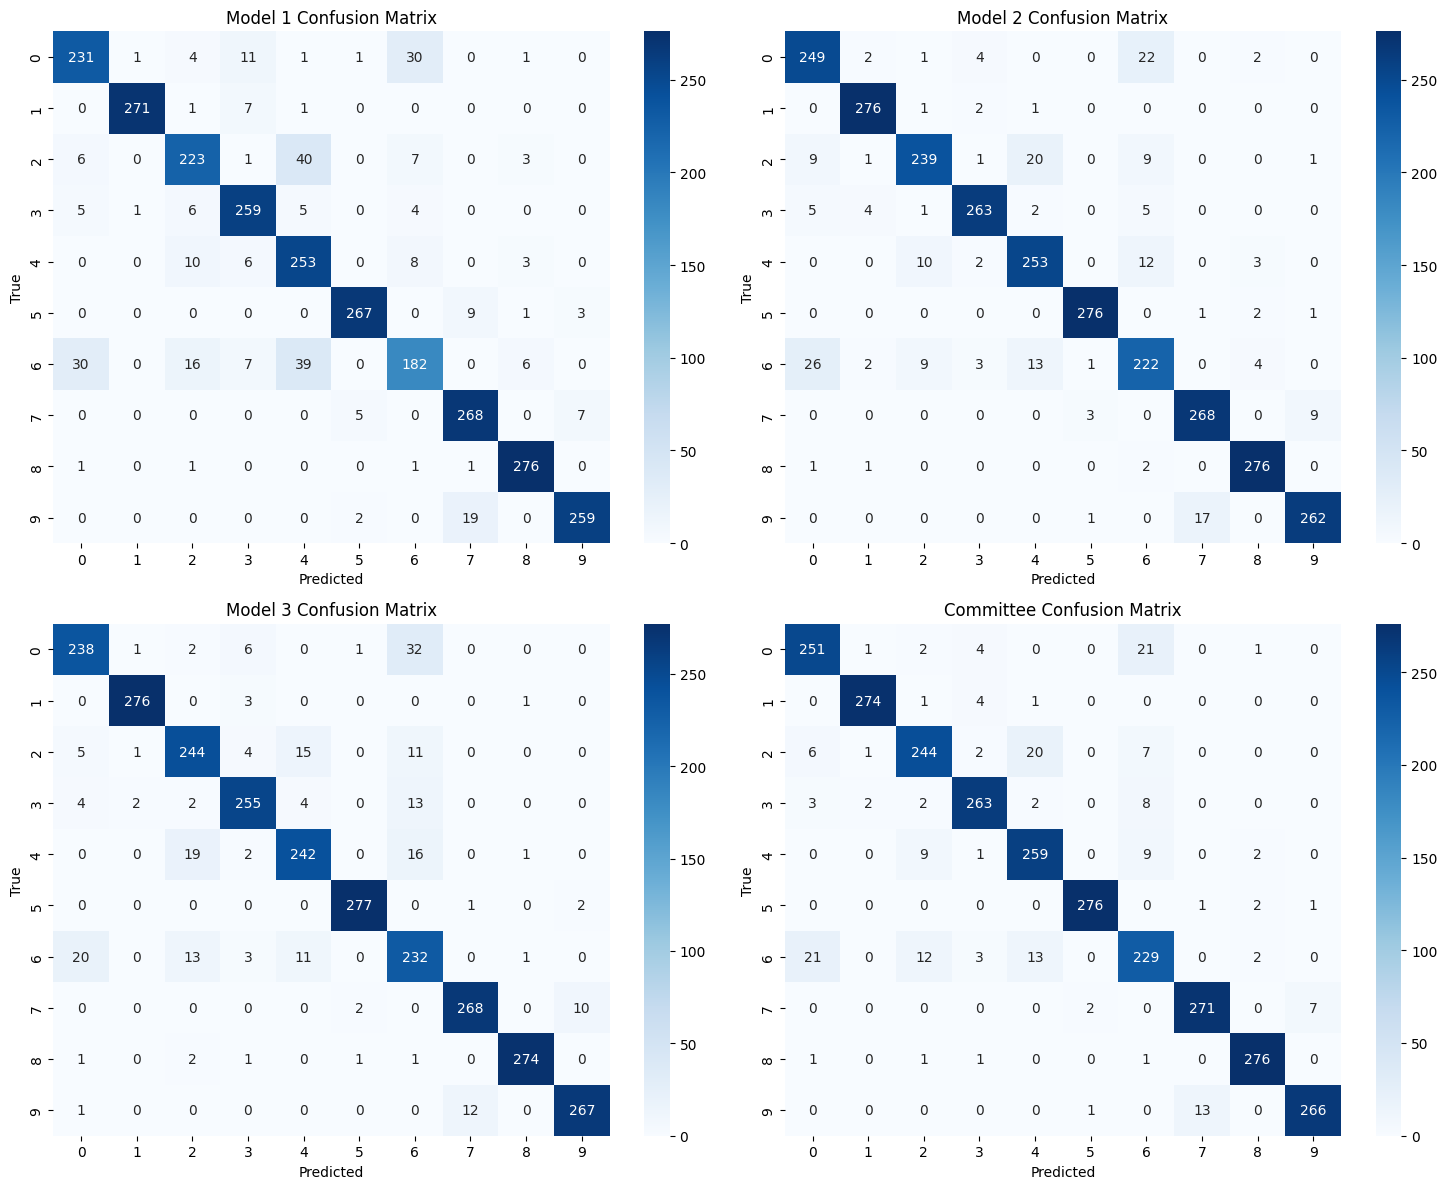

Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       280
           1       0.99      0.97      0.98       280
           2       0.85      0.80      0.82       280
           3       0.89      0.93      0.91       280
           4       0.75      0.90      0.82       280
           5       0.97      0.95      0.96       280
           6       0.78      0.65      0.71       280
           7       0.90      0.96      0.93       280
           8       0.95      0.99      0.97       280
           9       0.96      0.93      0.94       280

    accuracy                           0.89      2800
   macro avg       0.89      0.89      0.89      2800
weighted avg       0.89      0.89      0.89      2800

Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       280
           1       0.97      0.99      0.98       280
           2    

In [27]:
# Confusion matrix for models
cm1 = confusion_matrix(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cm2 = confusion_matrix(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cm3 = confusion_matrix(y_test.argmax(axis=1), predictions3.argmax(axis=1))

# Confusion matrix for the committee
cm_final = confusion_matrix(y_test.argmax(axis=1), final_predictions)

# Plot confusion matrix heatmaps
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Model 1 Confusion Matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax[0, 0])
ax[0, 0].set_title("Model 1 Confusion Matrix")
ax[0, 0].set_xlabel('Predicted')
ax[0, 0].set_ylabel('True')

# Model 2 Confusion Matrix
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[0, 1])
ax[0, 1].set_title("Model 2 Confusion Matrix")
ax[0, 1].set_xlabel('Predicted')
ax[0, 1].set_ylabel('True')

# Model 3 Confusion Matrix
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=ax[1, 0])
ax[1, 0].set_title("Model 3 Confusion Matrix")
ax[1, 0].set_xlabel('Predicted')
ax[1, 0].set_ylabel('True')

# Committee Confusion Matrix
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=ax[1, 1])
ax[1, 1].set_title("Committee Confusion Matrix")
ax[1, 1].set_xlabel('Predicted')
ax[1, 1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Classification reports
cr1 = classification_report(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), predictions3.argmax(axis=1))
cr_final = classification_report(y_test.argmax(axis=1), final_predictions)

# Print classification reports
print("Model 1 Classification Report:")
print(cr1)

print("Model 2 Classification Report:")
print(cr2)

print("Model 3 Classification Report:")
print(cr3)

print("Committee Classification Report:")
print(cr_final)


### Classification Report 

In [26]:
# Classification reports for each model and committee
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1), output_dict=True)
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1), output_dict=True)
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1), output_dict=True)
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions, output_dict=True)

# Convert the reports to DataFrame for easy visualization
df1 = pd.DataFrame(cr1).transpose()
df2 = pd.DataFrame(cr2).transpose()
df3 = pd.DataFrame(cr3).transpose()
df_committee = pd.DataFrame(cr_committee).transpose()

# Displaying the DataFrames in a readable format
print("Model 1 Classification Report")
print(df1)

print("Model 2 Classification Report")
print(df2)

print("Model 3 Classification Report")
print(df3)

print("Committee Classification Report")
print(df_committee)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 1 Classification Report
              precision    recall  f1-score      support
0              0.846154  0.825000  0.835443   280.000000
1              0.992674  0.967857  0.980108   280.000000
2              0.854406  0.796429  0.824399   280.000000
3              0.890034  0.925000  0.907180   280.000000
4              0.746313  0.903571  0.817447   280.000000
5              0.970909  0.953571  0.962162   280.000000
6              0.784483  0.650000  0.710938   280.000000
7              0.902357  0.957143  0.928943   280.000000
8              0.951724  0.985714  0.968421   280.000000
9              0.962825  0.925000  0.943534   280.000000
accuracy       0.888929  0.888929  0.888929     0.888929
macro avg      0.890188  0.888929  0.887858  2800.000000
weighted avg   0.890188  0.888929  0.887858  2800.000000
Model 2 Classification Report
              precisi

## Extra Task

### Model Setup with Batch Normalization and Dropout

In [29]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Data Augmentation

In [30]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

### Defining the model with Batch Normalization and Dropout

In [31]:
model = keras.Sequential([
    layers.InputLayer(input_shape=x_train.shape[1:]),  # Input shape (28, 28, 1)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compiling the model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

### Train the model:

In [33]:
# Train the model with data augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10


/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6587 - loss: 0.9890 - val_accuracy: 0.8363 - val_loss: 0.4355
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.7851 - loss: 0.5696 - val_accuracy: 0.8427 - val_loss: 0.4252
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8101 - loss: 0.5037 - val_accuracy: 0.8675 - val_loss: 0.3545
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8290 - loss: 0.4665 - val_accuracy: 0.8753 - val_loss: 0.3369
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8336 - loss: 0.4470 - val_accuracy: 0.8822 - val_loss: 0.3255
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8423 - loss: 0.4267 - val_accuracy: 0.7781 - val_loss: 0.6334
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8462 - loss: 0.4188 - val_accuracy: 0.8233 - val_loss: 0.4645
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8489 - loss: 0.4054 - val_accurac

In [34]:
model.save_weights('question2_fashion_mnist_model.weights.h5')

### Advanced ensembling:  (Weighted Averaging)

In [35]:
# Predictions from the models (example)
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by weighted averaging based on validation performance
weights = [0.5, 0.25, 0.25]  # Example weights
final_predictions = (weights[0] * predictions1 + weights[1] * predictions2 + weights[2] * predictions3)

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Committee accuracy: 0.9837


### Confusion Matrix Heatmaps

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


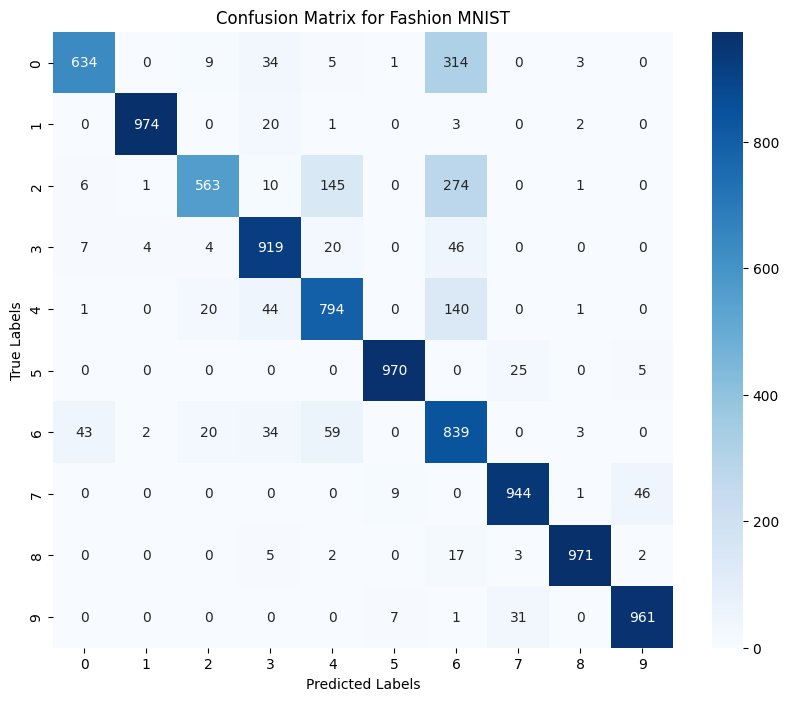

In [ ]:
y_pred = model.predict(x_test)

# Converting predictions from one-hot encoded to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Converting true labels (y_test) from one-hot encoded to class indices
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for Fashion MNIST")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Training Curves (Accuracy and Loss)

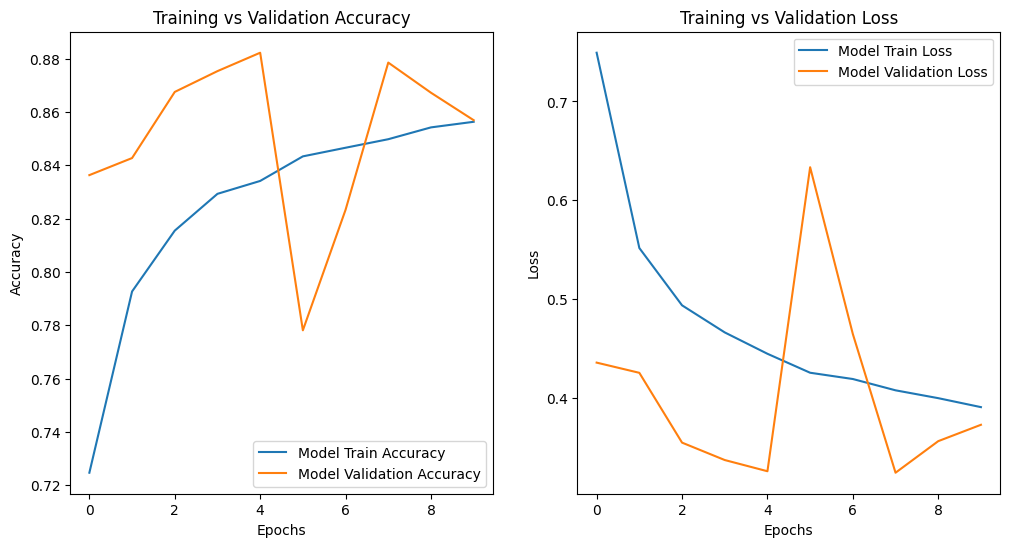

In [37]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Model Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model Train Loss')
plt.plot(history.history['val_loss'], label='Model Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Classification Reports

In [38]:
# Classification reports for the committee and individual models
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions)
print("Committee Classification Report")
print(cr_committee)

# You can also print classification reports for individual models like model1, model2, and model3
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1))

print("Model 1 Classification Report")
print(cr1)
print("Model 2 Classification Report")
print(cr2)
print("Model 3 Classification Report")
print(cr3)

Committee Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       1.00      0.99      1.00      1000
           2       0.97      0.97      0.97      1000
           3       0.98      0.98      0.98      1000
           4       0.97      0.99      0.98      1000
           5       1.00      1.00      1.00      1000
           6       0.97      0.93      0.95      1000
           7       0.99      1.00      0.99      1000
           8       0.99      1.00      1.00      1000
           9       1.00      0.99      0.99      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 1 Classification Report
              precision    recall  f1-score   suppor

## Question 2: Network with Batch Normalization and Dropout Layers

![Neural Network Architecture](./architecture.png)

In [31]:
# Load and preprocess Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Build the Wide & Deep model
input_layer = keras.Input(shape=(784,))

# Deep part
hidden1 = layers.Dense(30, activation='relu')(input_layer)
hidden1 = layers.BatchNormalization()(hidden1)
hidden1 = layers.Dropout(0.3)(hidden1)

hidden2 = layers.Dense(30, activation='relu')(hidden1)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(0.3)(hidden2)

# Wide + Deep concat
concat = layers.Concatenate()([input_layer, hidden2])

# Output layer
output = layers.Dense(10, activation='softmax')(concat)

In [32]:
#  Final model
model = keras.Model(inputs=[input_layer], outputs=[output])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30)        │     23,550 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30)        │        120 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30)        │        930 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30)        │        120 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 814)       │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │      8,150 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,870 (128.40 KB)

 Trainable params: 32,750 (127.93 KB)

 Non-trainable params: 120 (480.00 B)

In [33]:
# Train
history = model.fit(x_train, y_train_cat,
                    epochs=1000,
                    batch_size=64,
                    validation_data=(x_test, y_test_cat))

Epoch 1/1000


/home/asmae/Documents/wsu/sprinig-2025/machine-learning/assignment3_ML/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_31']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7455 - loss: 0.7589 - val_accuracy: 0.8311 - val_loss: 0.4775
Epoch 2/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8408 - loss: 0.4519 - val_accuracy: 0.8414 - val_loss: 0.4474
Epoch 3/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8519 - loss: 0.4254 - val_accuracy: 0.8526 - val_loss: 0.4184
Epoch 4/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8558 - loss: 0.4025 - val_accuracy: 0.8530 - val_loss: 0.4184
Epoch 5/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8563 - loss: 0.3967 - val_accuracy: 0.8537 - val_loss: 0.4196
Epoch 6/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8641 - loss: 0.3830 - val_accuracy: 0.8531 - val_loss: 0.4144
Epoch 7/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8646 - loss: 0.3858 - val_accuracy: 0.8555 - val_loss: 0.4069
Epoch 8/1000
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8645 - loss: 0.3840 - val_accuracy:

In [35]:
# Save the best model weights
model.save_weights('q2_fashion_mnist_model_best.weights.h5')

# Model Evaluation
test_loss, test_acc = model.evaluate(x_test, to_categorical(y_test), verbose=2)
print(f"Test accuracy: {test_acc}")

313/313 - 1s - 2ms/step - accuracy: 0.8611 - loss: 0.5023
Test accuracy: 0.8611000180244446


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step


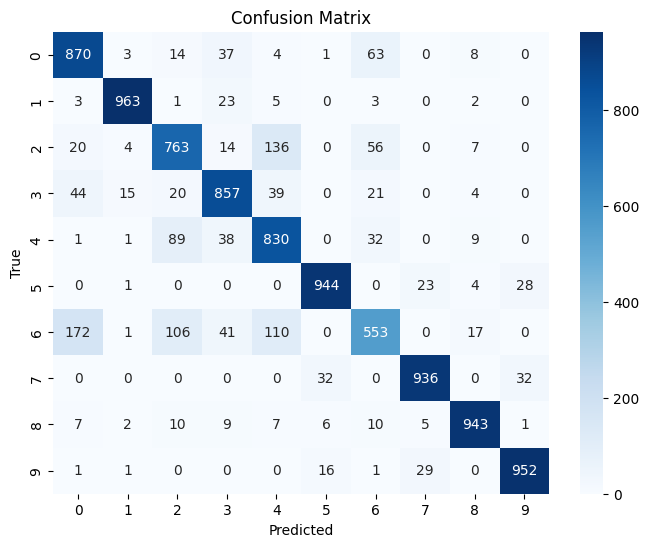

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1000
           1       0.97      0.96      0.97      1000
           2       0.76      0.76      0.76      1000
           3       0.84      0.86      0.85      1000
           4       0.73      0.83      0.78      1000
           5       0.94      0.94      0.94      1000
           6       0.75      0.55      0.64      1000
           7       0.94      0.94      0.94      1000
           8       0.95      0.94      0.95      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [36]:
# Confusion Matrix
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test

cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
cr = classification_report(true_classes, predicted_classes)
print("Classification Report")
print(cr)

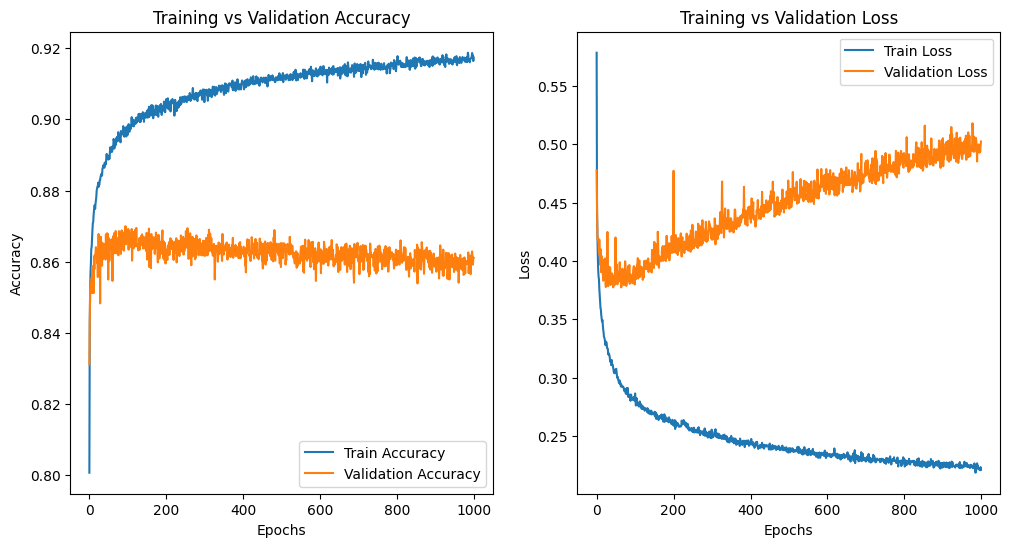

In [37]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()